<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_domowa_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [58]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # start tensors: 28x28x1
        # Convolutional layer 1: in_channels=1, out_channels=6, kernel_size=5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        #tensor after: 28x28x6

        # Subsampling layer 1: 2x2 average pooling
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 14x14x6

        # Convolutional layer 2: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        #tensor after: 10x10x16

        # Subsampling layer 2: 2x2 average pooling
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # input from previous feature map
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))   # Conv1 + Tanh
        x = self.pool1(x)           # Pool1
        x = torch.sigmoid(self.conv2(x))   # Conv2 + Tanh
        x = self.pool2(x)           # Pool2
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = torch.sigmoid(self.fc1(x))     # FC1 + Tanh
        x = torch.sigmoid(self.fc2(x))     # FC2 + Tanh
        x = self.fc3(x)             # Output layer (logits)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [60]:
# Check if GPU is available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(6):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cpu
epoch: 0 batch: 0 current batch loss: 2.404572010040283


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Testing
----------------------

In [4]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.7884


In [5]:
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def dream_digits_l2(model, num_steps=600, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 kara (kwadraty wart. pixeli)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

cuda


Step 0 | CE Loss: 3.1036 | L2: 1.0195 | Mean Conf: 0.0914
Step 50 | CE Loss: 0.4072 | L2: 1.6360 | Mean Conf: 0.6814
Step 100 | CE Loss: 0.3993 | L2: 1.4138 | Mean Conf: 0.6862
Step 150 | CE Loss: 0.3966 | L2: 1.2032 | Mean Conf: 0.6879
Step 200 | CE Loss: 0.3952 | L2: 1.0362 | Mean Conf: 0.6888
Step 250 | CE Loss: 0.3942 | L2: 0.9039 | Mean Conf: 0.6895
Step 300 | CE Loss: 0.3934 | L2: 0.7975 | Mean Conf: 0.6901
Step 350 | CE Loss: 0.3929 | L2: 0.7096 | Mean Conf: 0.6905
Step 400 | CE Loss: 0.3927 | L2: 0.6377 | Mean Conf: 0.6906
Step 450 | CE Loss: 0.3926 | L2: 0.5790 | Mean Conf: 0.6907
Step 500 | CE Loss: 0.3926 | L2: 0.5312 | Mean Conf: 0.6907
Step 550 | CE Loss: 0.3926 | L2: 0.4921 | Mean Conf: 0.6907
Step 599 | CE Loss: 0.3926 | L2: 0.4605 | Mean Conf: 0.6907


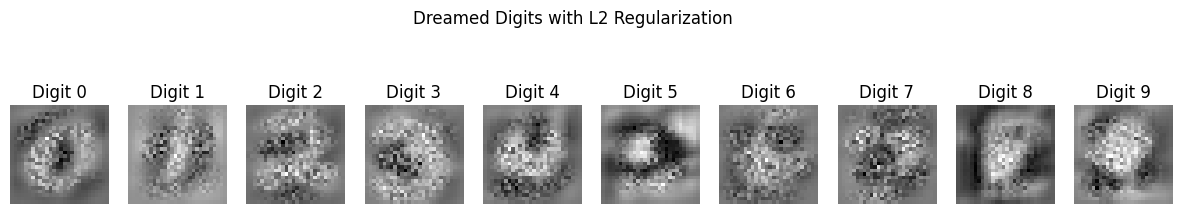

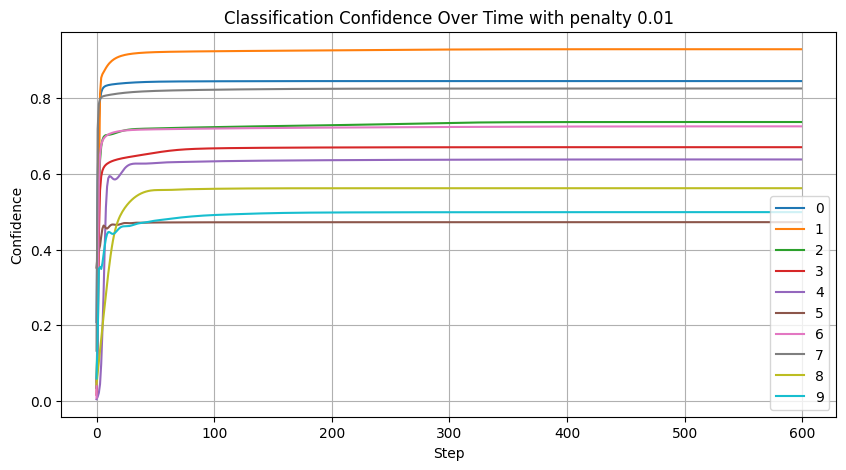

Step 0 | CE Loss: 2.8903 | L2: 0.9992 | Mean Conf: 0.1148
Step 50 | CE Loss: 0.4046 | L2: 0.8522 | Mean Conf: 0.6832
Step 100 | CE Loss: 0.3986 | L2: 0.4481 | Mean Conf: 0.6869
Step 150 | CE Loss: 0.3977 | L2: 0.2696 | Mean Conf: 0.6875
Step 200 | CE Loss: 0.3981 | L2: 0.1846 | Mean Conf: 0.6872
Step 250 | CE Loss: 0.3985 | L2: 0.1424 | Mean Conf: 0.6869
Step 300 | CE Loss: 0.3987 | L2: 0.1206 | Mean Conf: 0.6868
Step 350 | CE Loss: 0.3987 | L2: 0.1088 | Mean Conf: 0.6867
Step 400 | CE Loss: 0.3987 | L2: 0.1021 | Mean Conf: 0.6867
Step 450 | CE Loss: 0.3988 | L2: 0.0981 | Mean Conf: 0.6867
Step 500 | CE Loss: 0.3988 | L2: 0.0958 | Mean Conf: 0.6867
Step 550 | CE Loss: 0.3988 | L2: 0.0944 | Mean Conf: 0.6867
Step 599 | CE Loss: 0.3988 | L2: 0.0936 | Mean Conf: 0.6867


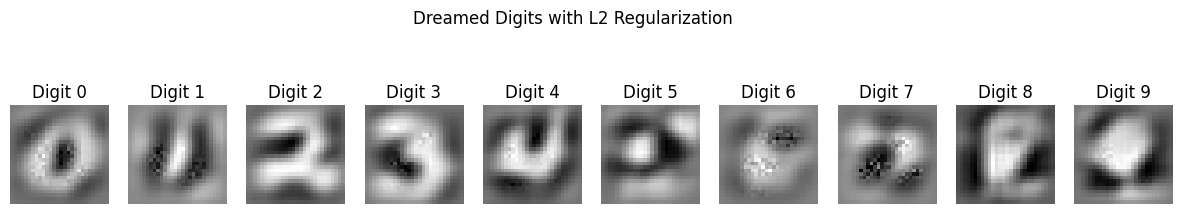

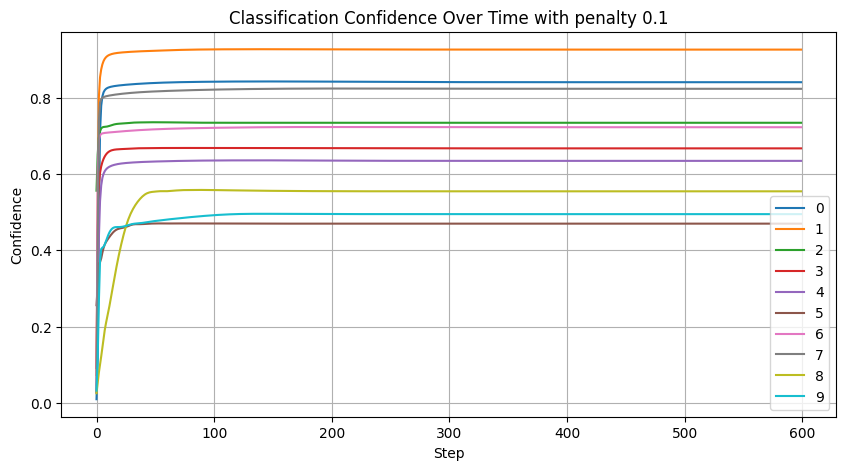

Step 0 | CE Loss: 3.2773 | L2: 1.0143 | Mean Conf: 0.0643
Step 50 | CE Loss: 0.4169 | L2: 0.1246 | Mean Conf: 0.6755
Step 100 | CE Loss: 0.4181 | L2: 0.0363 | Mean Conf: 0.6744
Step 150 | CE Loss: 0.4181 | L2: 0.0317 | Mean Conf: 0.6744
Step 200 | CE Loss: 0.4181 | L2: 0.0313 | Mean Conf: 0.6744
Step 250 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744
Step 300 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744
Step 350 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744
Step 400 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744
Step 450 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744
Step 500 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744
Step 550 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744
Step 599 | CE Loss: 0.4181 | L2: 0.0312 | Mean Conf: 0.6744


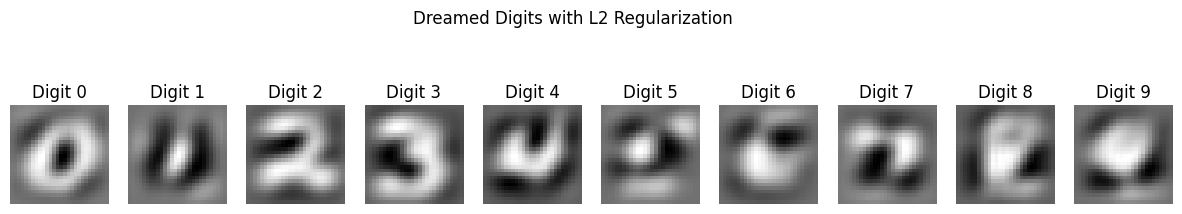

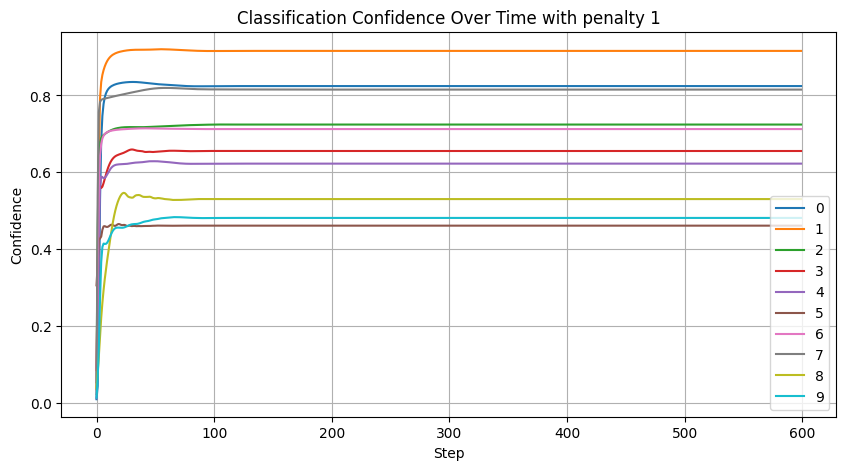

Step 0 | CE Loss: 3.5174 | L2: 1.0250 | Mean Conf: 0.0581
Step 50 | CE Loss: 0.4863 | L2: 0.0142 | Mean Conf: 0.6325
Step 100 | CE Loss: 0.4831 | L2: 0.0111 | Mean Conf: 0.6345
Step 150 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 200 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 250 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 300 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 350 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 400 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 450 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 500 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 550 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346
Step 599 | CE Loss: 0.4830 | L2: 0.0111 | Mean Conf: 0.6346


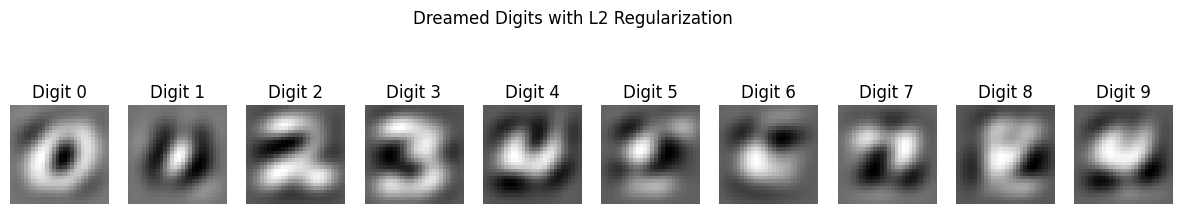

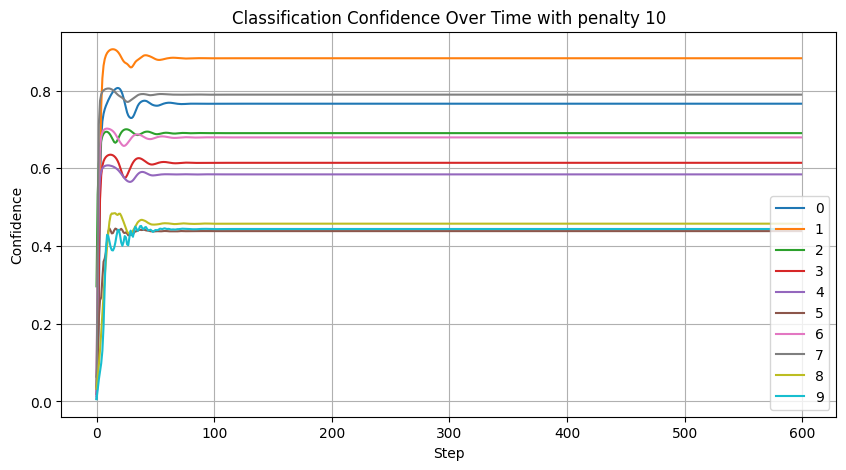

Step 0 | CE Loss: 3.4519 | L2: 1.0054 | Mean Conf: 0.0703
Step 50 | CE Loss: 0.7394 | L2: 0.0059 | Mean Conf: 0.5031
Step 100 | CE Loss: 0.7387 | L2: 0.0035 | Mean Conf: 0.5035
Step 150 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 200 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 250 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 300 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 350 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 400 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 450 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 500 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 550 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036
Step 599 | CE Loss: 0.7386 | L2: 0.0035 | Mean Conf: 0.5036


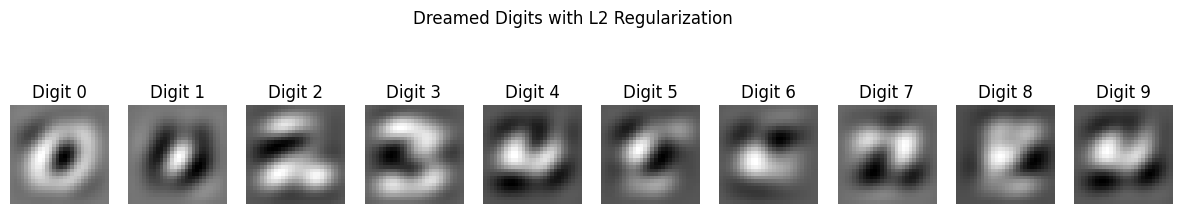

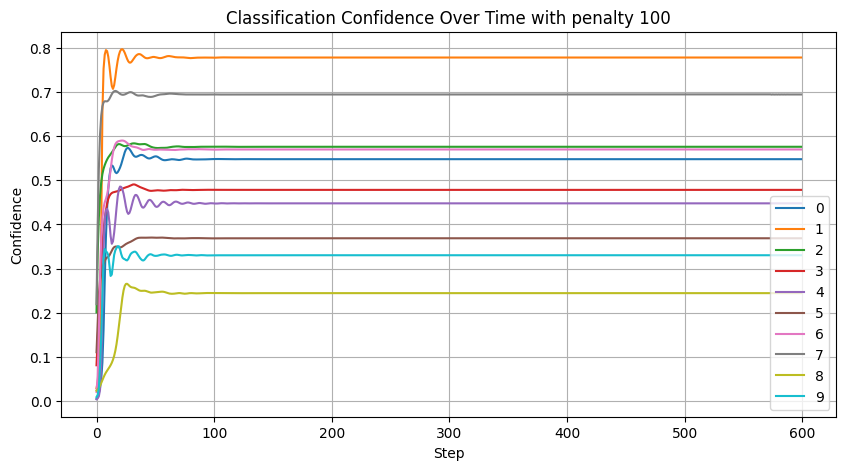

In [6]:
def plot_task3_results(images, history, lambda_l2):

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()


    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title(f"Classification Confidence Over Time with penalty {lambda_l2}")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()
    # test dla różnych kar.
for lam in [0.01, 0.1, 1, 10, 100]:
  final_images, confidence_history = dream_digits_l2(net, lambda_l2=lam)

  plot_task3_results(final_images, confidence_history, lam)

# Adwersaryjna część

In [52]:
def generate_adversarial_example(x, y_wrong, model, lambda_l2=0.01, num_steps=50, lr=0.01):

    x = x.clone().detach()
    x = x.to(device)

    delta = torch.zeros_like(x, requires_grad=True).to(device)

    # Choose a wrong target class
    y_wrong_tensor = torch.tensor([y_wrong], device=device)
    #print(y_wrong_tensor.dim())
    optimizer = torch.optim.Adam([delta], lr=lr)
    #print(x.dtype, y_wrong.dtype)
    history = []
    for _ in range(num_steps):
        optimizer.zero_grad()

        output = model(x + delta)
        loss = F.cross_entropy(output, y_wrong_tensor) + lambda_l2 * delta.pow(2).mean()

        loss.backward()
        optimizer.step()


        # Optional: clamp to [0, 1] valid pixel range
        delta.data = torch.clamp(x + delta.data, 0, 1) - x
        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            #print(x.dtype, y.dtype)
            confidence = probs[0, y_wrong].item()
            history.append(confidence)

    x_adv = x + delta.detach()
    return x_adv, y_wrong, history

In [14]:
def show_images(original, adversarial, orig_pred, adv_pred):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title(f'Original (Pred: {orig_pred})')
    axs[1].imshow(adversarial.squeeze(), cmap='gray')
    axs[1].set_title(f'Adversarial (Pred: {adv_pred})')
    for ax in axs:
        ax.axis('off')
    #plt.suptitle(f'Example {i}')
    plt.show()

In [46]:
# just history plots
def pl_hist(history, lambda_l2, true_label):
    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[i], label=f"{i}")
    plt.title(f"Classification Confidence Over Time with penalty {lambda_l2}")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()

In [54]:
lambda_l2 = 10
found_pairs = set()  # To track completed (y_true, y_wrong) pairs
max_per_pair = 1     # Just one example per (true, target) pair
success_counts= [[0 for i in range(10)] for j in range(10)]
trials_counts= [[0 for i in range(10)] for j in range(10)]
for i, (x, y) in enumerate(testloader):
    print(i)
    if i >= 200:
      break
    y_true = y.item()
    x = x.to(device)
    y = y.to(device)

    if net(x).argmax(dim=1).item() != y_true:
        continue
    for y_wrong in range(10):
        if y_wrong == y_true:
            continue
        pair = (y_true, y_wrong)  # Already done this pair
        trials_counts[y_true][y_wrong] +=1
        # Run adversarial generation
        x_adv, _, conf_hist = generate_adversarial_example(x, y_wrong, net, lambda_l2=lambda_l2)

        with torch.no_grad():
            adv_pred = net(x_adv).argmax(dim=1).item()

        if adv_pred == y_wrong:
            success_counts[y_true][y_wrong]+=1

            if success_counts[y_true] [y_wrong] == 1:
              print(f"Found adversarial example for True={y_true}, Target={y_wrong}")

              show_images(x.squeeze().detach().cpu().numpy(), x_adv.squeeze().detach().cpu().numpy(), y_true, y_wrong)
              #pl_hist(conf_hist, lambda_l2, y_true)
              # Optional: Save or show the image
              '''plt.imshow(x.squeeze().detach().cpu().numpy(), cmap='gray')
              plt.show()
              plt.imshow(x_adv.squeeze().detach().cpu().numpy(), cmap='gray')
              plt.show()'''
              # save_image(x_adv, f"adv_{y_true}_to_{y_wrong}.png")

        # Stop early if all 90 pairs are collected
        '''if len(found_pairs) >= 30:
            break

    if len(found_pairs) >= 30:
        break'''

0


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:
rates = np.array(success_counts)/np.array(trials_counts)
print(rates)

[[       nan 0.         1.         1.         0.04347826 0.
  0.13043478 0.04347826 0.26086957 0.        ]
 [1.                nan 1.         1.         1.         0.65853659
  1.         1.         1.         1.        ]
 [0.85185185 0.                nan 1.         0.07407407 0.14814815
  0.25925926 0.07407407 0.59259259 0.07407407]
 [0.94444444 0.         1.                nan 0.22222222 0.5
  0.38888889 0.5        0.61111111 0.16666667]
 [1.         0.         1.         1.                nan 0.44
  1.         0.88       1.         0.88      ]
 [1.         0.06666667 1.         1.         0.6               nan
  0.8        0.73333333 0.93333333 0.86666667]
 [1.         0.         1.         1.         0.52380952 0.42857143
         nan 0.23809524 0.9047619  0.28571429]
 [1.         0.         0.96153846 1.         0.34615385 0.5
  0.5               nan 1.         1.        ]
 [1.         0.         1.         1.         0.35714286 0.
  0.5        0.14285714        nan 0.42857143]
 

<ipython-input-22-d4fbb2a6bbad>:1: RuntimeWarning: invalid value encountered in divide
  rates = np.array(success_counts)/np.array(trials_counts)
